# (Style) Transfer of terrain morphological structure 
In this notebook I demonstrate the possibility of using style transfer for transferring geological/morphological terrain information from real maps to randomly generated maps. 
We therefore prove the capability of style transfer to capture these properties independently form the content of the map. 

Style transfer works with 2d images, so we need some ideas on how to apply this technique on 3d terrain maps. The general approach I've chosen is to use 2d height maps as as input and output for the style transfer. Luckly height maps for the entire planet are available from the open source project "https://tangrams.github.io/heightmapper/"

In style transfer we need to use **content image** and **style image**, in this case we use as style image a region of the world and as content image a procedurally generated map from the previous notebook. 

## The Data
The data for this notebook is stored in a small dataset of my creation, freely published on Kaggle. It contains a set of procedurally generated maps and a set of height maps from region of the real world. In this brief notebook I'll reproduce some terrain with the style of the italian alps, other attempts were made with different types of terrain, but they've been computed in different instances.

In [1]:
#select the input images from the dataset 
base_image_path = "../input/noise-yeye/noise600_5.png"
style_reference_image_path = "../input/noise-yeye/valley2.jpg"

The content image: A procedurally generated map with perlin noise and gaussian filtering. 

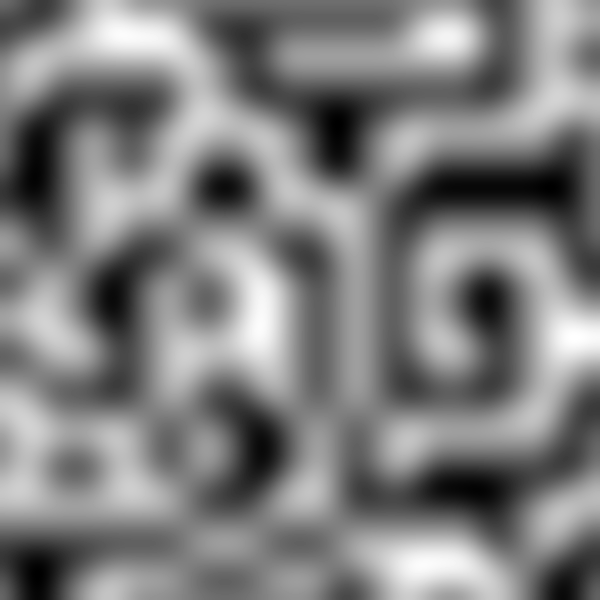

In [2]:
from IPython.display import Image, display
display(Image(base_image_path))

The style image: my home town, the italian alps

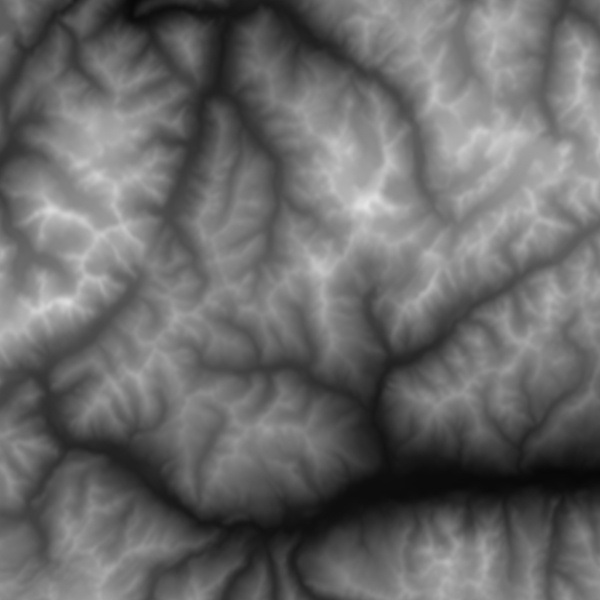

In [3]:
display(Image(style_reference_image_path))

## Transferring the Style
The following implementation of style transfer was made by modifying an opensource implementation by F.Chollet. The general tuning of the network needed a general overhaul to work with morphological structure of terrain maps. Briefly, the network needed to be tuned heavily in the direction of style, discarding content. The convoluted layer for the pulling of style are as numerous as possible, the content is measured on the last convoluted layer only. 

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

result_prefix = "style_noise"

# style is increased, total variation and content reduced. 
total_variation_weight = 1e-10
style_weight = 1e-5
content_weight = 2.5e-11

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 600
img_ncols = int(width * img_nrows / height)

Like most of Style transfer implementation, the network is based on the VGG19 convoluted pretrained network.


![vgg19 structure](https://miro.medium.com/max/1200/1*U6_b8aNUtOgdkRlP3b9Vpg.jpeg)

In [5]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## Compute the style transfer loss

we need to define 4 utility functions.
gram matrix is used to compute the style between the layers, while the content loss directly computed. 
We also add a total variation loss that helps with local consistency. 

- `gram_matrix` (used to compute the style loss)
- The `style_loss` function, which keeps the generated image close to the local textures
of the style reference image
- The `content_loss` function, which keeps the high-level representation of the
generated image close to that of the base image
- The `total_variation_loss` function, a regularization loss which keeps the generated
image locally-coherent

In [6]:
# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [7]:
#the feature extractor

# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

2022-01-22 13:59:48.257419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 13:59:48.345361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 13:59:48.346039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 13:59:48.347303: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step


In [8]:
# List of layers to use for the style loss.

#For transferring the morphological structure we select all the 1st convoluted layer from all 5 blocks
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1"
]
# The layer to use for the content loss.

#Only the 2nd conv layer from the last block
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


In [9]:
#Added for performance purpose for loss & gradient computation

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## The training loop 
We run the gradient descent with SGD, for 2000 iterations; save the image every 200 iterations for keepeing track of the changes.

We use a decay rate, set to 0.96 everyt 100 steps.



In [10]:
from datetime import datetime

In [11]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=150.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 2000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 200 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        print(datetime.now())
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)


2022-01-22 13:59:53.287072: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-22 13:59:54.309302: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Iteration 200: loss=744.04
2022-01-22 14:00:35.222060
Iteration 400: loss=181.85
2022-01-22 14:01:08.260864
Iteration 600: loss=152.40
2022-01-22 14:01:41.347062
Iteration 800: loss=134.48
2022-01-22 14:02:14.496437
Iteration 1000: loss=122.70
2022-01-22 14:02:47.663156
Iteration 1200: loss=114.05
2022-01-22 14:03:20.835364
Iteration 1400: loss=107.33
2022-01-22 14:03:53.993899
Iteration 1600: loss=101.97
2022-01-22 14:04:27.152662
Iteration 1800: loss=97.60
2022-01-22 14:05:00.299730
Iteration 2000: loss=93.98
2022-01-22 14:05:33.464108


## Checking the results
plotting the created image, we see that the morphological information were transferred. We can easily see valleys between the edges. 

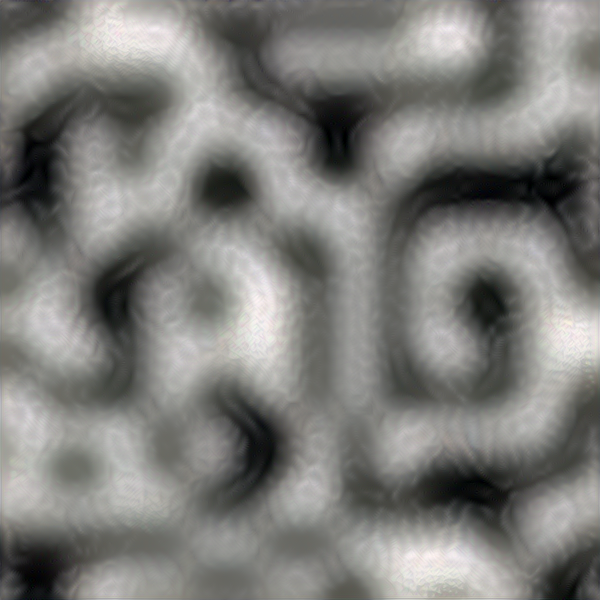

In [12]:
display(Image("style_noise_at_iteration_2000.png"))

In [13]:
from matplotlib import image
from matplotlib import pyplot as plt
# load image as pixel array
#plt.imsave("jeez.png",gaussian_filter(create_perlin_noise(600),kernel,sigma=8),cmap="gray")
result_image = image.imread('style_noise_at_iteration_2000.png')
original_image = image.imread(base_image_path)

result_image = np.asarray(result_image)
result_image = result_image[:,:,1]

original_image = np.asarray(original_image)
original_image = original_image[:,:,1]

We can also note that the general content of the image is mantained. The style was transferred but no general content with it. 

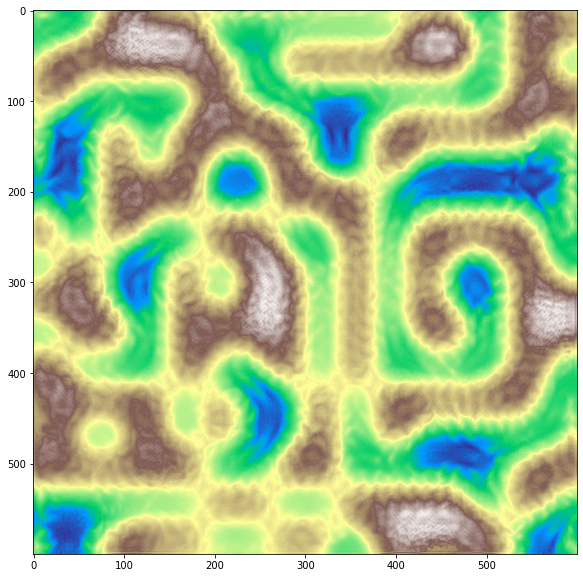

In [14]:
#the "alpine" terrain
plt.figure(figsize=(10,10))
plt.imshow(result_image,origin='upper',cmap='terrain')

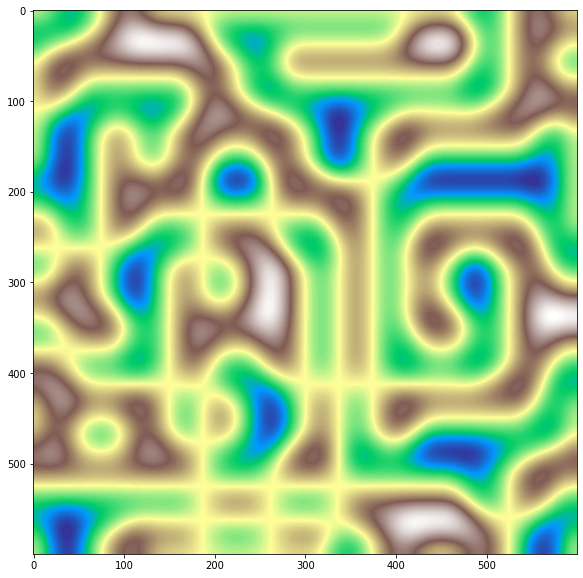

In [15]:
#the original terrain
plt.figure(figsize=(10,10))
plt.imshow(original_image,origin='upper',cmap='terrain')

## Plotting the 3d models 
lets 3d plot the map, more extensive results are discussed outside of the notebook as the computation is heavy on cpus and must be executed on proper hardware. 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  """


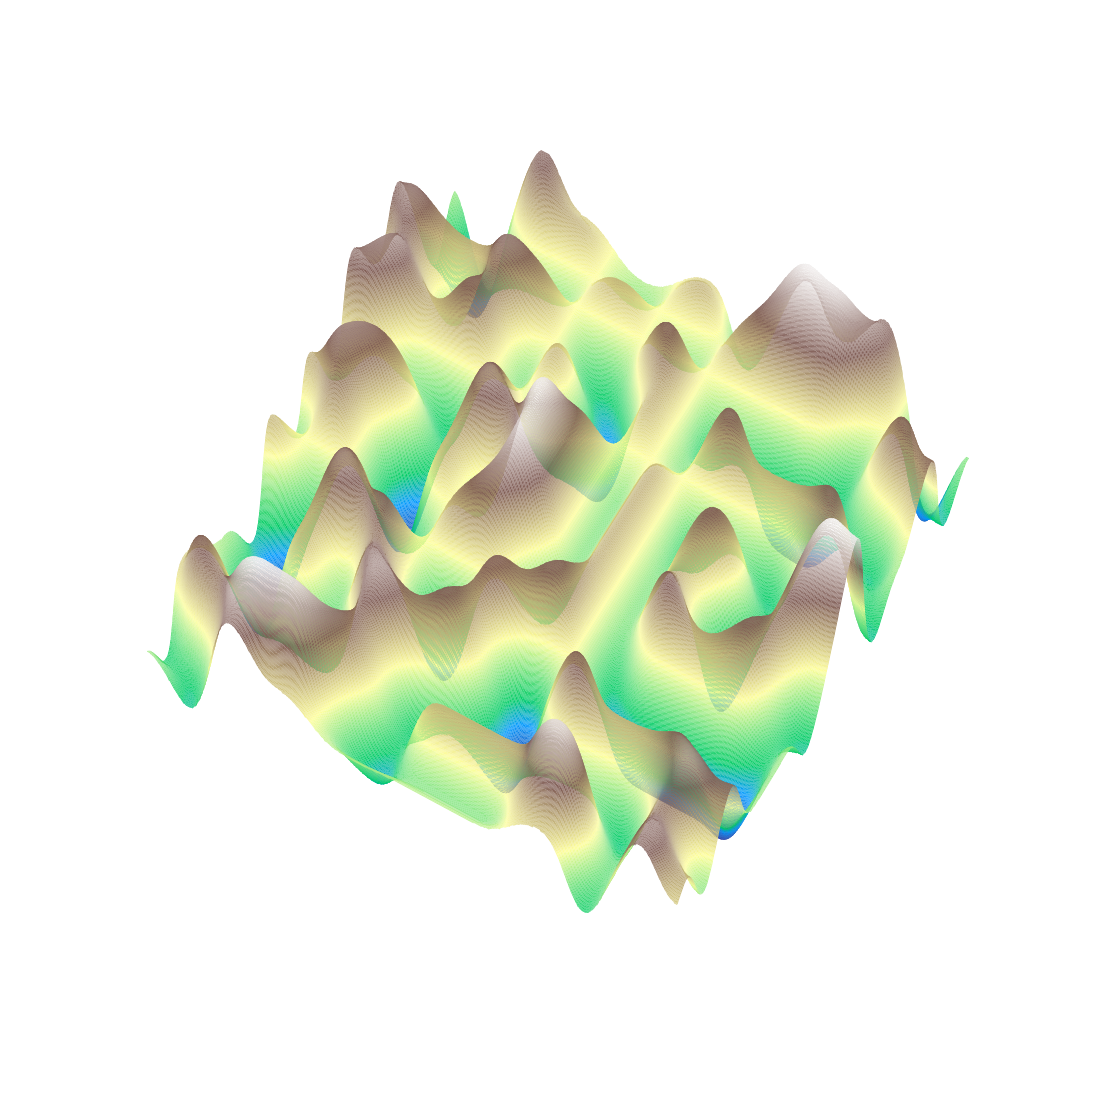

In [16]:
from mpl_toolkits.mplot3d.axes3d import *
from matplotlib import cm

fig = plt.figure(figsize=(15,15))
ax = Axes3D(fig)
# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis('off')
#use a meshgrid to generate x and y coordinates, z are pulled straight from the matrix
X = np.arange(0, 600, 1)
Y = np.arange(0, 600, 1)
X, Y = np.meshgrid(X, Y)
ax.plot_surface(X, Y, original_image ,rstride=1, cstride=1, cmap='terrain',linewidth=1, antialiased=True)
ax.view_init(elev=65)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  """


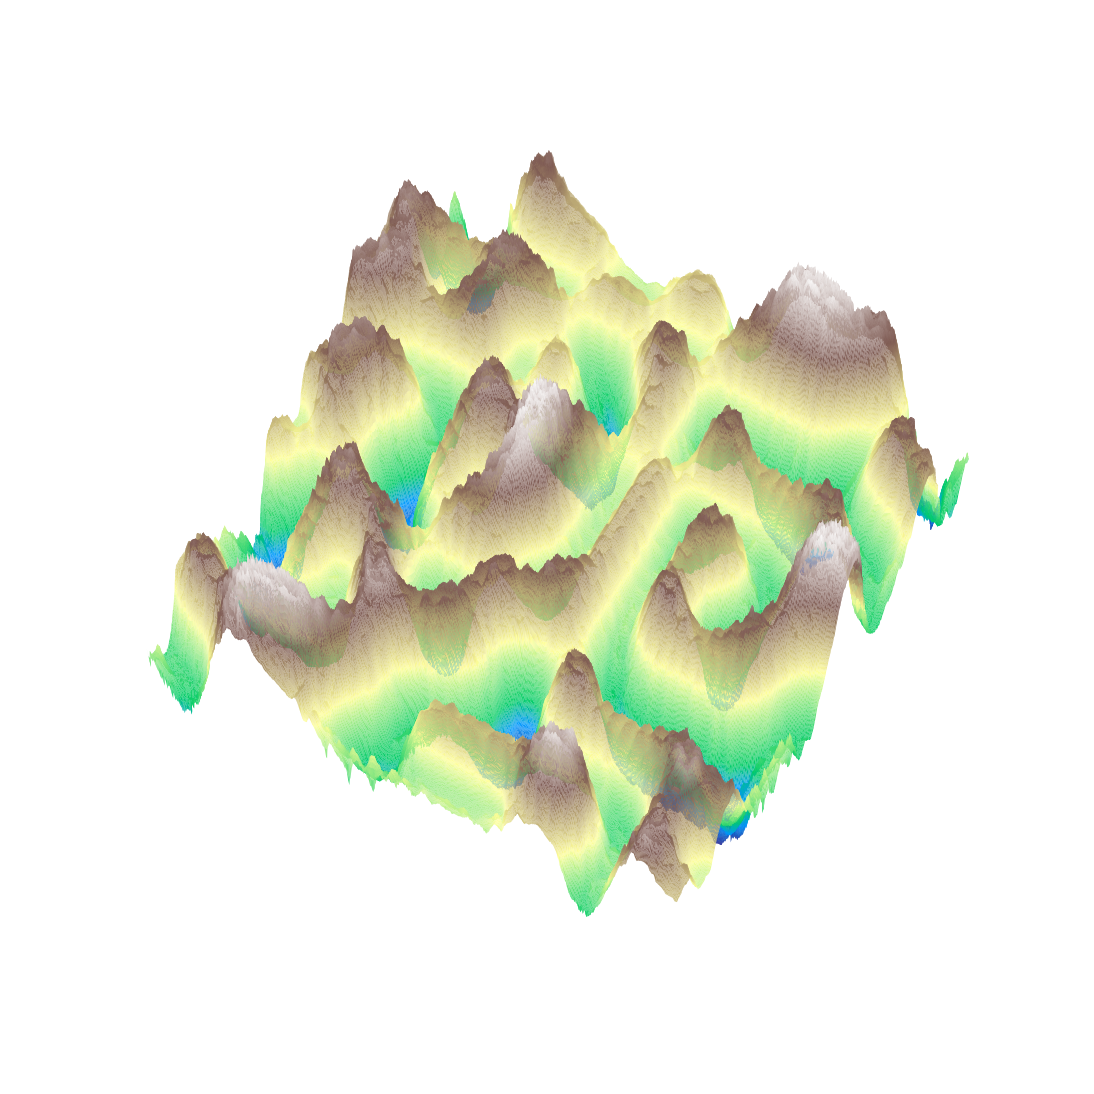

In [17]:
from mpl_toolkits.mplot3d.axes3d import *
from matplotlib import cm

fig = plt.figure(figsize=(15,15))
ax = Axes3D(fig)
#ax = fig.add_subplot(projection='3d')
# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#ax.set_box_aspect((1, 1, 1)) 
plt.axis('off')
#use a meshgrid to generate x and y coordinates, z are pulled straight from the matrix
X = np.arange(0, 600, 1)
Y = np.arange(0, 600, 1)
X, Y = np.meshgrid(X, Y)
ax.plot_surface(X, Y, result_image ,rstride=1, cstride=1, cmap='terrain',linewidth=1, antialiased=True)
ax.view_init(elev=65)
plt.show()

## check the image from which we pulled the morphological structure
below is 3d plotted the orginal image from which style was pulled. 

In [18]:
style_image = image.imread(style_reference_image_path)

style_image = np.asarray(style_image)
style_image = style_image[:,:,1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  """


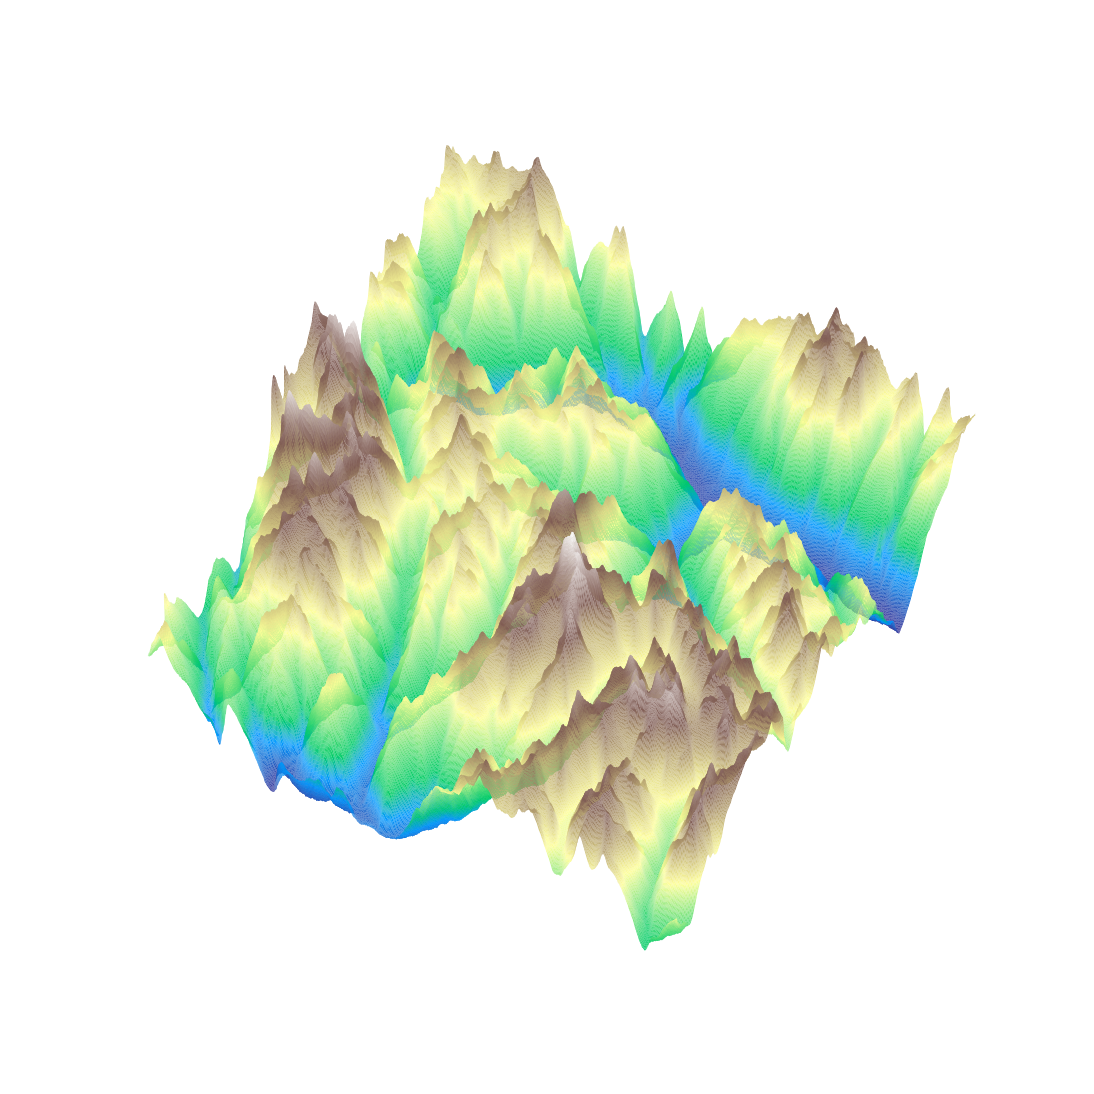

In [19]:
from mpl_toolkits.mplot3d.axes3d import *
from matplotlib import cm

fig = plt.figure(figsize=(15,15))
ax = Axes3D(fig)
#ax = fig.add_subplot(projection='3d')
# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#ax.set_box_aspect((1, 1, 1)) 
plt.axis('off')
#use a meshgrid to generate x and y coordinates, z are pulled straight from the matrix
X = np.arange(0, 600, 1)
Y = np.arange(0, 600, 1)
X, Y = np.meshgrid(X, Y)
ax.plot_surface(X, Y, style_image ,rstride=1, cstride=1, cmap='terrain',linewidth=1, antialiased=True)
ax.view_init(elev=65)
plt.show()